# EarthDaily datacube: Agro Cloud Mask and Native Cloud Mask with Sentinel-2 images comparison

This notebook illustrate the added value of Earthdaiy Agro Ag cloud mask compared to standard SCL mask using two datacubes of reflectances.

For this example the data cubes have been generated using https://github.com/earthdaily/reflectance-datacube-processor with the following parameters:
- Geometry: "POLYGON ((1.26 43.427, 1.263 43.428, 1.263 43.426, 1.26 43.426, 1.26 43.427))"
- Collection: Sentinel-2-l2a
- Dates: 2019-04-01 to 2019-06-30
- Bands: red, green, blue, nir 
- Clear coverage : 80 
- One datacube with native cloud mask (SCL) and one with ag cloud mask



 ## 1️⃣ Import all librairies needed 

In [1]:
import sys
import os
sys.path.append(os.path.join('..','src'))
from dotenv import load_dotenv
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
# read .env file
load_dotenv()
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from utils.utils import open_datacube
from cloudpathlib import S3Path, AzureBlobClient, AzureBlobPath

## 2️⃣ Load Datacubes from Cloud Storage (AWS or Azure)

- Load Datacubes from AWS

In [ ]:
# Load datacube with the Agro Cloud Mask
image_ACM = S3Path("s3://" + os.getenv("AWS_BUCKET_NAME") + "/2019-04-01_2019-06-30_entity_agro_cloud_sentinel-2-l2a_datacube.zarr")
cube_ACM = open_datacube(image_ACM)

In [3]:
# Load datacube with the Native Cloud Mask
image_native = S3Path("s3://" + os.getenv("AWS_BUCKET_NAME") + "/2019-04-01_2019-06-30_entity_native_cloud_sentinel-2-l2a_datacube.zarr")
cube_native= open_datacube(image_native)

- Load Datacubes from Azure Cloud Storage

In [2]:
# Init Azure account/credentials
account_url = f"https://{os.environ['AZURE_ACCOUNT_NAME']}.blob.core.windows.net"
az_client = AzureBlobClient(account_url, credential = os.environ['AZURE_SAS_CREDENTIAL'])

In [ ]:
# Load datacube with the Agro Cloud Mask
uri_ACM = "az://" + os.getenv("AZURE_BLOB_CONTAINER_NAME") + "/2019-04-01_2019-06-30_entity_agro_cloud_sentinel-2-l2a_datacube.zarr"
path_ACM = AzureBlobPath(uri_ACM,client=az_client)
cube_ACM = open_datacube(path_ACM)

In [5]:
# Load datacube with the Native Cloud Mask
uri_native = "az://" + os.getenv("AZURE_BLOB_CONTAINER_NAME") + "/2019-04-01_2019-06-30_entity_native_cloud_sentinel-2-l2a_datacube.zarr"
path_native = AzureBlobPath(uri_native,client=az_client)
cube_native = open_datacube(path_native)

## 3️⃣ Plot the NDVI rasters by dates for the native cloud mask and the agro cloud mask

In [6]:
def NDVI(red,nir):
    return((nir - red)/(nir + red))

In [7]:
dates_native=[]
NDTIs_native=[]
for date,cube_date in cube_native.groupby('time',squeeze=False):
    NDTIs_native.append(NDVI(cube_date.red,cube_date.nir08))
    dates_native.append(date)
print(len(NDTIs_native))

5


In [8]:
dates_ACM=[]
NDTIs_ACM=[]
for date,cube_date in cube_ACM.groupby('time',squeeze=False):
    NDTIs_ACM.append(NDVI(cube_date.red,cube_date.nir08))
    dates_ACM.append(date)
print(len(NDTIs_ACM))

3


- Plot NDVI images with the Native Cloud Mask

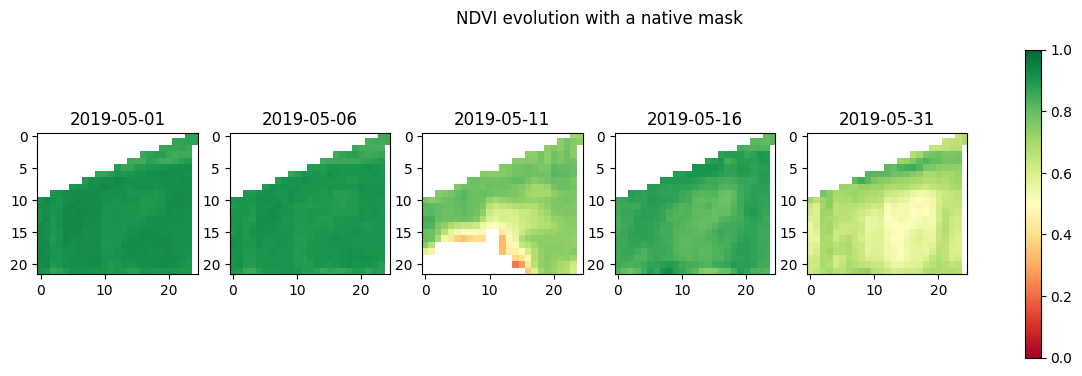

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(15, 4))
fig.suptitle('NDVI evolution with a native mask')
for i, ax in enumerate(axes.flat):
    ax.set_title(str(dates_native[i])[:10])
    im = ax.imshow(NDTIs_native[i][0],vmin=0.0,vmax=1,cmap='RdYlGn')
cax,kw = mpl.colorbar.make_axes(list(axes.flat))
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

- Plot NDVI images with the Agro Cloud Mask

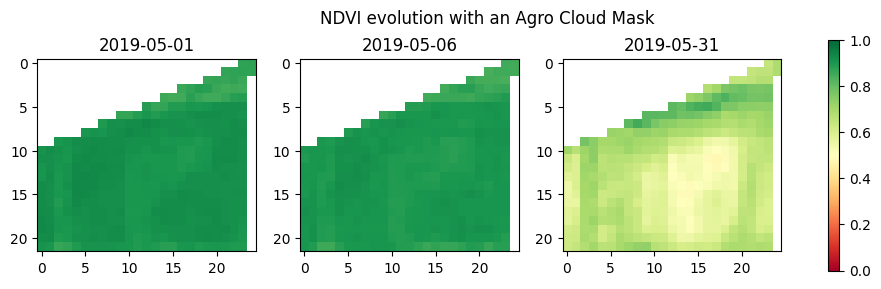

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12, 3))
fig.suptitle('NDVI evolution with an Agro Cloud Mask')
for i, ax in enumerate(axes.flat):
    ax.set_title(str(dates_ACM[i])[:10])
    im = ax.imshow(NDTIs_ACM[i][0],vmin=0.0,vmax=1,cmap='RdYlGn')
cax,kw = mpl.colorbar.make_axes(list(axes.flat))
plt.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.show()

## 4️⃣ RGB image of a cloudy day

The Agro cloud mask allowed to detect more cloudy days than the native mask. For example, on May 11th 2019, the field was partially covered with clouds, not detected by the native cloud mask but detected by our mask.

c:\Users\kls\AppData\Local\anaconda3\envs\reflectance-processor\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


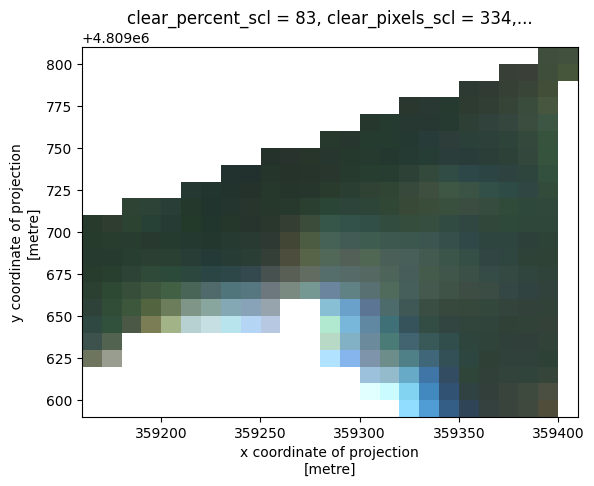

In [12]:
cube_native.sel(time='2019-05-11T00:00:00.000000000')[["red", "green", "blue"]].to_array(
    dim="band"
).plot.imshow(vmin=0, vmax=0.2)

In this RGB image, we can see that part of the field is cloudy. With our internal Agro Cloud Mask, this image is not selected because of the coverage.